# Artificial Neural Networks and Deep Learning



---



## Homework 1: Minimal Working Example



To make your first submission, follow these steps:

1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.

2. Upload the `training_set.npz` file to this folder.

3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.

4. Load and process the data.

5. Implement and train your model.

6. Submit the generated `.zip` file to Codabench.



## ⚙️ Import Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_cv
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow import keras as tfk
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers as tfkl
from tensorflow.keras import models

In [2]:
np.random.seed(24) # for reproducibility
tf.random.set_seed(24)

### Variables

In [3]:
already_augmented = False
balance_training = True
learning_rate = 1e-4
N_freeze = 220
dropout_rate_last = 0.3
patience = 20
batch_size = 64
epochs = 200

## ⏳ Load the Data

In [4]:
data = np.load('/kaggle/input/training-set/training_set.npz')  # Load the training data here

X = data['images']
Y = data['labels']

print('images datased dim:', X.shape)
print('labels dataset dim:', Y.shape)

images datased dim: (13759, 96, 96, 3)
labels dataset dim: (13759, 1)


In [5]:
print(np.unique(Y)) # LABELS
labels = {
    0: 'Basophil',
    1: 'Eosinophil',
    2: 'Erythroblast',
    3: 'Immature granulocytes',
    4: 'Lymphocyte',
    5: 'Monocyte',
    6: 'Neutrophil',
    7: 'Platelet'
}

[0 1 2 3 4 5 6 7]


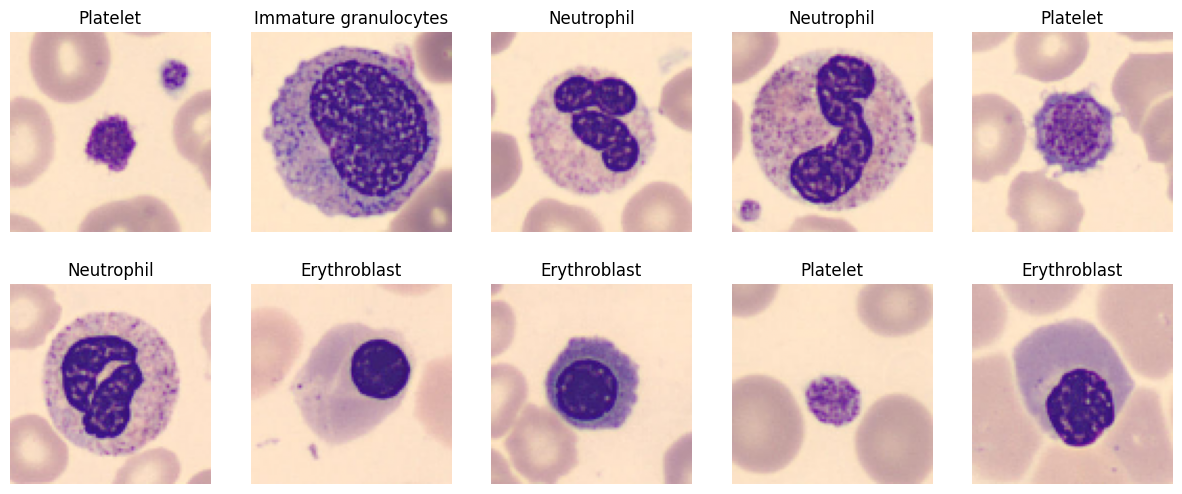

In [6]:
# show some images and relative labels
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax[i // 5, i % 5].imshow(X[i]/255)
    ax[i // 5, i % 5].set_title(labels[Y[i][0]])
    ax[i // 5, i % 5].axis('off')
plt.show()

### Outliers Remove

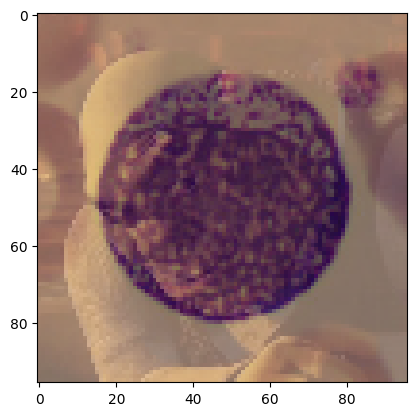

In [7]:
shrek = X[-1800]
plt.imshow(shrek)

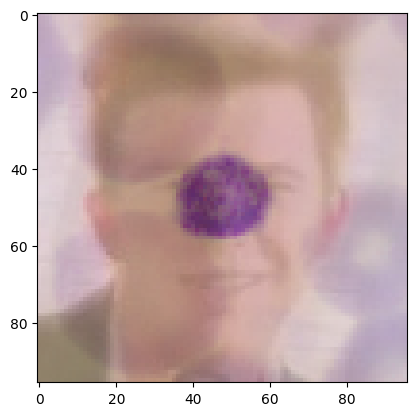

In [8]:
rick = X[-200]
plt.imshow(rick)

In [9]:
t = X[np.all(X == rick, axis=(1, 2, 3))]
p = X[np.all(X == shrek, axis=(1, 2, 3))]
t.shape, p.shape

((200, 96, 96, 3), (1600, 96, 96, 3))

In [10]:
X = X[:-1800]
Y = Y[:-1800]

In [11]:
t = X[np.all(X == rick, axis=(1, 2, 3))]
p = X[np.all(X == shrek, axis=(1, 2, 3))]
t.shape, p.shape

((0, 96, 96, 3), (0, 96, 96, 3))

In [12]:
Y = tfk.utils.to_categorical(Y, num_classes=len(labels))
print(X.shape)
print(Y.shape)

(11959, 96, 96, 3)
(11959, 8)


#### Dataset Distribution

<StemContainer object of 3 artists>

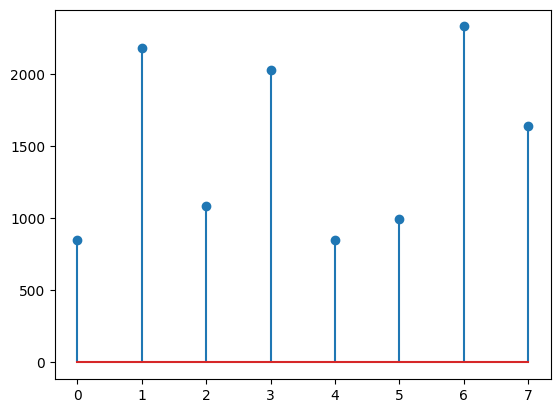

In [13]:
plt.stem(Y.sum(axis=0)) 

### Dataset Split

In [14]:
X_d, X_test, Y_d, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_d, Y_d, test_size=0.1, random_state=42)


print('Train size: ', X_train.shape)
print('Valid size: ', X_valid.shape)
print('Test size: ', X_test.shape)

Train size:  (8610, 96, 96, 3)
Valid size:  (957, 96, 96, 3)
Test size:  (2392, 96, 96, 3)


In [15]:
# remove the duplicates from train dataset
uniques = np.unique(X_train, return_index=True, axis=0)

X_train = X_train[uniques[1]]
Y_train = Y_train[uniques[1]]

In [16]:
print('Train size: ', X_train.shape)
print('Valid size: ', X_valid.shape)
print('Test size: ', X_test.shape)

Train size:  (8606, 96, 96, 3)
Valid size:  (957, 96, 96, 3)
Test size:  (2392, 96, 96, 3)


(96, 96, 3)


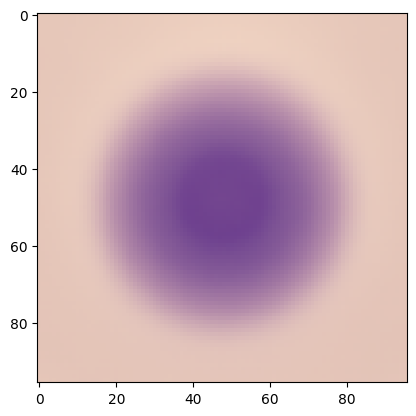

In [17]:
#Visualize the mean:
mean = X_train.mean(axis=0)
print(mean.shape)
plt.imshow(mean/255)

### Data Augmententation and Class Balance

In [18]:
classes = Y_train.sum(axis=0)
max_class = np.max(classes) + 1500
remaining = np.round(max_class - classes).astype(int)
remaining

array([2562, 1579, 2375, 1686, 2579, 2453, 1500, 1996])

[ 605. 1588.  792. 1481.  588.  714. 1667. 1171.]


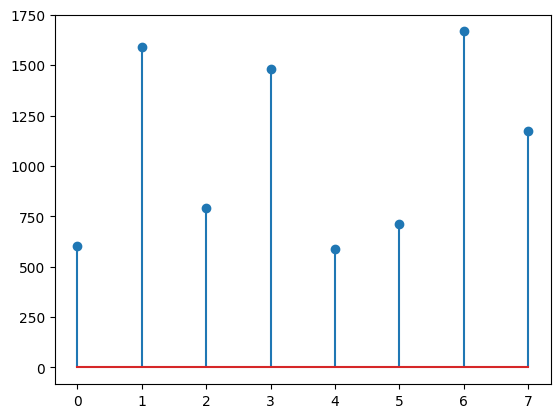

In [19]:
plt.stem(Y_train.sum(axis=0))
print(classes)

Basophil
(2562, 96, 96, 3) (2562, 8)
Eosinophil
(4141, 96, 96, 3) (4141, 8)
Erythroblast
(6516, 96, 96, 3) (6516, 8)
Immature granulocytes
(8202, 96, 96, 3) (8202, 8)
Lymphocyte
(10781, 96, 96, 3) (10781, 8)
Monocyte
(13234, 96, 96, 3) (13234, 8)
Neutrophil
(14734, 96, 96, 3) (14734, 8)
Platelet
(16730, 96, 96, 3) (16730, 8)
(16730, 8)
New dim X:  (25336, 96, 96, 3)
New dim Y:  (25336, 8)


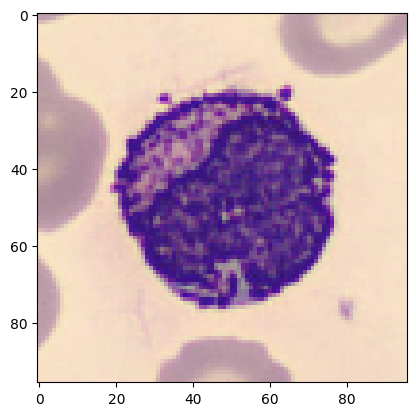

In [20]:
if not already_augmented:  #use AugMix to augment the Train Set
    
    augmix = keras_cv.layers.AugMix([0, 255])
    class_counts_aug = np.zeros(8).astype(int)
    print(labels[0])
    
    augmented = augmix(X_train[Y_train[:, 0] == 1][:remaining[0]])
    augmented_lbls = np.zeros((augmented.shape[0], 8))
    augmented_lbls[:, 0] = 1
    class_counts_aug[0] = augmented.shape[0]

    while class_counts_aug[0] < remaining[0]:
        diff = remaining[0]-class_counts_aug[0]
        if diff <= 0:
            diff = 1
        tmp = augmix(X_train[Y_train[:, 0] == 1][:diff])
        lbls = np.zeros((tmp.shape[0], 8))
        lbls[:, 0] = 1
        class_counts_aug[0] += tmp.shape[0]
        augmented = np.append(augmented, tmp, axis=0)
        augmented_lbls = np.append(augmented_lbls, lbls, axis=0)

    print(augmented.shape, augmented_lbls.shape)

    for i in range(1, 8):
        print(labels[i])
        while class_counts_aug[i] < remaining[i]:
            diff = remaining[i]-class_counts_aug[i]
            if diff <= 0:
                diff = 1
            tmp = augmix(X_train[Y_train[:, i] == 1][:diff])
            lbls = np.zeros((tmp.shape[0], 8))
            lbls[:, i] = 1
            class_counts_aug[i] += tmp.shape[0]
            augmented = np.append(augmented, tmp, axis=0)
            augmented_lbls = np.append(augmented_lbls, lbls, axis=0)
        print(augmented.shape, augmented_lbls.shape)

    plt.figure()
    plt.imshow(augmented[30]/255)
    print(augmented_lbls.shape)
    
    X_train = np.append(X_train, augmented, axis=0)
    Y_train = np.append(Y_train, augmented_lbls, axis=0)
    
    np.savez_compressed('new_X_train', X_train)
    np.savez_compressed('new_Y_train', Y_train)
    
else:
    X_train = np.load('/kaggle/input/preeprocessing-dataset/new_X_train_compressed.npz')
    Y_train = np.load('/kaggle/input/preeprocessing-dataset/new_Y_train_compressed.npz')
    
    X_train = X_train['arr_0']
    Y_train = Y_train['arr_0']

print("New dim X: ", X_train.shape)
print("New dim Y: ", Y_train.shape)

[3167. 3167. 3167. 3167. 3167. 3167. 3167. 3167.]


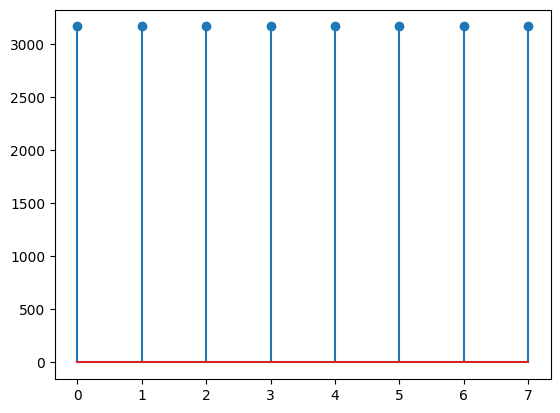

In [21]:
classes = Y_train.sum(axis=0) #class distribution after balance and augmentation
plt.stem(Y_train.sum(axis=0))
print(classes)

### ImageDataGenerator

In [22]:
# Set up ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'  # Fill in missing pixels
)

val_datagen = ImageDataGenerator()

train_datagen.fit(X_train)
val_datagen.fit(X_valid)

# Generate batches of augmented data from numpy arrays
train_generator = train_datagen.flow(
    x=X_train, y=Y_train,
    batch_size=batch_size
)

val_generator = val_datagen.flow(
    x=X_valid, y=Y_valid,
    batch_size=batch_size
)


396
(64, 96, 96, 3)
(64,)


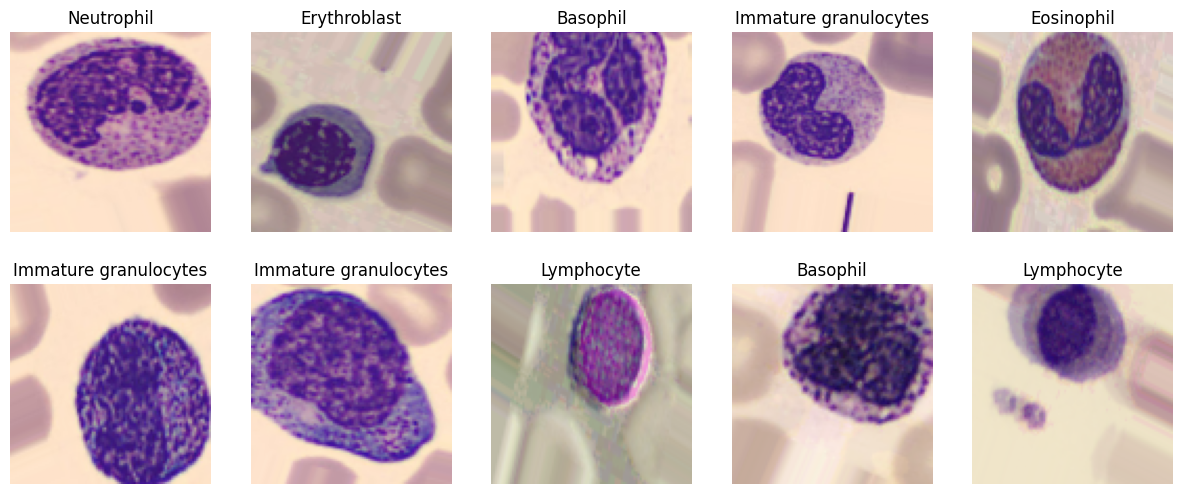

In [23]:
print(len(train_generator))
batch = train_generator[0]
imgs = batch[0] /255 #rescaling is important
lab = np.argmax(batch[1], axis=1)
print(imgs.shape)
print(lab.shape)

fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax[i // 5, i % 5].imshow(imgs[i])
    ax[i // 5, i % 5].set_title(labels[lab[i]])
    ax[i // 5, i % 5].axis('off')
plt.show()

## 🛠️ Train and Save the Model

### Base Model: EfficientNetV2S

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "efficientnetv2-s"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 96, 96,  │         0 │ -              │   -   │
│ (InputLayer)      │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ rescaling         │ (None, 96, 96,  │         0 │ input_layer[0… │   -   │
│ (Rescaling)       │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_conv         │ (None, 48, 48,  │       648 │ rescaling[0][… │   Y   │
│ (Conv2D)          │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_bn           │ (None, 48, 48,  │        96 │ stem_conv[0][… │   Y   │
│ (BatchNormalizat… │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_activation   │ (None, 48, 48,  │         0 │ stem_bn[0][0]  │   -   │
│ (Activation)      │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 48, 48,  │     5,184 │ stem_activati… │   Y   │
│ (Conv2D)          │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 48, 48,  │        96 │ block1a_proje… │   Y   │
│ (BatchNormalizat… │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 48, 48,  │         0 │ block1a_proje… │   -   │
│ (Activation)      │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_add (Add) │ (None, 48, 48,  │         0 │ block1a_proje… │   -   │
│                   │ 24)             │           │ stem_activati… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_project_… │ (None, 48, 48,  │     5,184 │ block1a_add[0… │   Y   │
│ (Conv2D)          │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_project_… │ (None, 48, 48,  │        96 │ block1b_proje… │   Y   │
│ (BatchNormalizat… │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_project_… │ (None, 48, 48,  │         0 │ block1b_proje… │   -   │
│ (Activation)      │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_drop      │ (None, 48, 48,  │         0 │ block1b_proje… │   -   │
│ (Dropout)         │ 24)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_add (Add) │ (None, 48, 48,  │         0 │ block1b_drop[… │   -   │
│                   │ 24)             │           │ block1a_add[0… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2a_expand_c… │ (None, 24, 24,  │    20,736 │ block1b_add[0… │   Y   │
│ (Conv2D)          │ 96)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2a_expand_bn │ (None, 24, 24,  │       384 │ block2a_expan… │   Y   │
│ (BatchNormalizat… │ 96)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2a_expand_a… │ (None, 24, 24,  │         0 │ block2a_expan… │   - 

 Total params: 20,331,360 (77.56 MB)

 Trainable params: 20,177,488 (76.97 MB)

 Non-trainable params: 153,872 (601.06 KB)

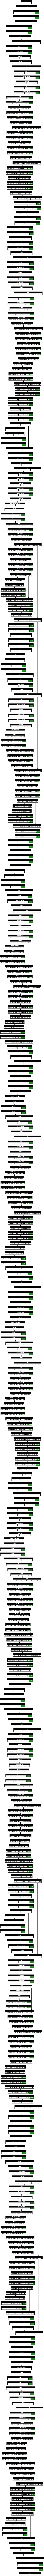

In [24]:
# Initialise model with pretrained weights, for transfer learning
base_model = tfk.applications.EfficientNetV2S(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet'
)

base_name = base_model.name

# Display a summary of the model architecture
base_model.summary(show_trainable=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(base_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [25]:
len(base_model.layers)

513

In [26]:
base_model.trainable = False

### Transfer Learning

In [27]:
# Define input layer with shape matching the input images
inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

x = tfk.applications.efficientnet_v2.preprocess_input(inputs)
x = base_model(x, training=False)

x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.BatchNormalization()(x)  #Batch Normalization
x = tfkl.Dropout(0.5)(x)  #Regularize with dropout

#6 blocks composed by Dense, Dropout and BatchNormalization layers with different parameters
x = tfkl.Dense(1024, activation='relu')(x)  
x = tfkl.Dropout(0.3)(x)  #to prevent overfitting
x = tfkl.BatchNormalization()(x)

x = tfkl.Dense(512, activation='relu')(x)  
x = tfkl.Dropout(0.4)(x)  
x = tfkl.BatchNormalization()(x)

x = tfkl.Dense(256, activation='relu')(x)  
x = tfkl.Dropout(0.5)(x)  
x = tfkl.BatchNormalization()(x)

x = tfkl.Dense(128, activation='relu')(x)  
x = tfkl.Dropout(0.4)(x)  
x = tfkl.BatchNormalization()(x)

x = tfkl.Dense(32, activation='relu')(x)  
x = tfkl.Dropout(0.4)(x)  
x = tfkl.BatchNormalization()(x)

x = tfkl.Dense(16, activation='relu')(x)  
x = tfkl.Dropout(0.2)(x)  
x = tfkl.BatchNormalization()(x)

# Final output layer for classification
outputs = tfkl.Dense(8, activation='softmax', name='dense_output')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with categorical cross-entropy loss and Adam optimiser
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-3), metrics=['accuracy'])

# Display a summary of the model architecture
tl_model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 3, 3, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 22,349,912 (85.26 MB)

 Trainable params: 2,012,056 (7.68 MB)

 Non-trainable params: 20,337,856 (77.58 MB)

In [28]:
# callbacks definition
reduce_lr = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',             # Monitor validation loss
    factor=0.2,                     # Reduce the learning rate by a factor of 0.2
    patience=10,                    # Wait for 5 epochs before reducing the learning rate
    min_lr=1e-8,                    # Minimum learning rate THIS COULD BE BIGGERRR
    verbose=1
)

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',     # Monitor val accuracy
    mode='max', 
    patience=patience,    
    restore_best_weights=True   # Save the best weights
)

callbacks = [reduce_lr, early_stopping]

In [29]:
# Train the model
tl_history = tl_model.fit(
    train_generator,
    batch_size=batch_size,
    validation_data=val_generator,
    epochs=200,
    callbacks=callbacks
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
tl_model.save('weights_untuned.keras')

# Free memory by deleting the model instance
del tl_model

Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732275603.061059      69 service.cc:145] XLA service 0x56fb4e52f510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732275603.061153      69 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/396 ━━━━━━━━━━━━━━━━━━━━ 11:36:23 106s/step - accuracy: 0.1094 - loss: 2.7385

I0000 00:00:1732275684.512483      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


396/396 ━━━━━━━━━━━━━━━━━━━━ 253s 373ms/step - accuracy: 0.2049 - loss: 2.2092 - val_accuracy: 0.6311 - val_loss: 1.0434 - learning_rate: 0.0010
Epoch 2/200
396/396 ━━━━━━━━━━━━━━━━━━━━ 57s 141ms/step - accuracy: 0.4767 - loss: 1.4204 - val_accuracy: 0.7325 - val_loss: 0.7619 - learning_rate: 0.0010
Epoch 3/200
396/396 ━━━━━━━━━━━━━━━━━━━━ 57s 141ms/step - accuracy: 0.5663 - loss: 1.2199 - val_accuracy: 0.7910 - val_loss: 0.6495 - learning_rate: 0.0010
Epoch 4/200
396/396 ━━━━━━━━━━━━━━━━━━━━ 57s 142ms/step - accuracy: 0.6252 - loss: 1.1278 - val_accuracy: 0.8255 - val_loss: 0.5480 - learning_rate: 0.0010
Epoch 5/200
396/396 ━━━━━━━━━━━━━━━━━━━━ 57s 142ms/step - accuracy: 0.6404 - loss: 1.0900 - val_accuracy: 0.8339 - val_loss: 0.5208 - learning_rate: 0.0010
Epoch 6/200
396/396 ━━━━━━━━━━━━━━━━━━━━ 57s 140ms/step - accuracy: 0.6679 - loss: 1.0275 - val_accuracy: 0.8861 - val_loss: 0.4416 - learning_rate: 0.0010
Epoch 7/200
396/396 ━━━━━━━━━━━━━━━━━━━━ 57s 142ms/step - accuracy: 0.6753 

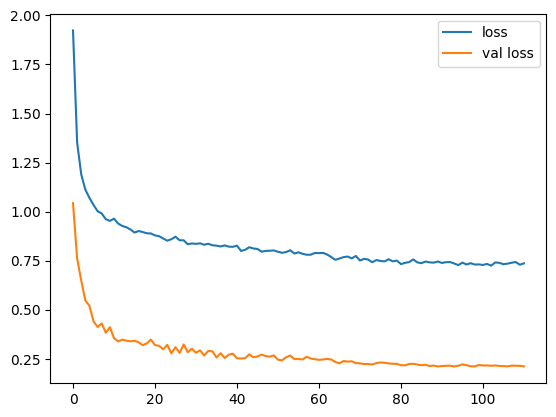

In [30]:
plt.plot(tl_history['loss'], label='loss')
plt.plot(tl_history['val_loss'], label='val loss')
plt.legend()

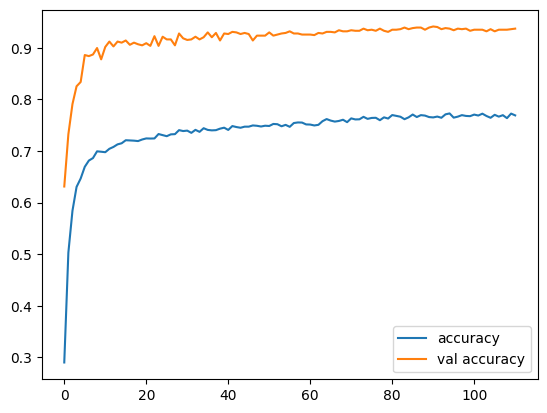

In [31]:
plt.plot(tl_history['accuracy'], label='accuracy')
plt.plot(tl_history['val_accuracy'], label='val accuracy')
plt.legend()

### Fine Tuning

In [32]:
ft_model = tfk.models.load_model('weights_untuned.keras')

ft_model.get_layer(base_name).trainable = True # set all layers to trainable

# Display a summary of the model architecture
ft_model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 3, 3, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 26,374,026 (100.61 MB)

 Trainable params: 22,189,544 (84.65 MB)

 Non-trainable params: 160,368 (626.44 KB)

 Optimizer params: 4,024,114 (15.35 MB)

In [33]:
# Set all layers as non-trainable
for layer in ft_model.get_layer(base_name).layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(ft_model.get_layer(base_name).layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
        #print(i, layer.name, type(layer).__name__, layer.trainable)


# Set the number of layers to freeze
N = 120

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer(base_name).layers[:N]):
    layer.trainable = False

ft_model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 3, 3, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 26,374,026 (100.61 MB)

 Trainable params: 20,634,720 (78.72 MB)

 Non-trainable params: 1,715,192 (6.54 MB)

 Optimizer params: 4,024,114 (15.35 MB)

In [34]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])

In [35]:
# Initialize counters for trainable and non-trainable layers
total_trainable_layers = 0 # Count of layers with trainable parameters
total_non_trainable_layers = 0 # Count of layers with frozen (non-trainable) parameters

for layer in ft_model.layers:
    if isinstance(layer, tf.keras.Model): # Check if the layer is part of base model
        trainable_count = 0
        non_trainable_count = 0
        
        for sub_layer in layer.layers:  # Iterate through the layers of the base model
            if sub_layer.trainable:
                trainable_count += 1
                total_trainable_layers += 1
            else:
                non_trainable_count += 1
                total_non_trainable_layers += 1
    else:
        if layer.trainable:
            total_trainable_layers += 1
        else:
            total_non_trainable_layers += 1
    
print(f"\nTotale: {total_trainable_layers} trainable layers, {total_non_trainable_layers} non-trainable layers")


Totale: 155 trainable layers, 381 non-trainable layers


In [36]:
# Fine-tune the model
ft_history = ft_model.fit(
    train_generator,
    batch_size=batch_size,
    epochs = 200,
    validation_data = val_generator,
    callbacks = callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'weights.keras'
ft_model.save(model_filename)

# Delete the model to free up resources
del ft_model

Epoch 1/200


I0000 00:00:1732282140.114240      68 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_16', 440 bytes spill stores, 476 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_15', 104 bytes spill stores, 132 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 44 bytes spill stores, 44 bytes spill loads



357/396 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.8402 - loss: 0.5508

I0000 00:00:1732282290.178887      70 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_14', 440 bytes spill stores, 476 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_13', 104 bytes spill stores, 132 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 44 bytes spill stores, 44 bytes spill loads



396/396 ━━━━━━━━━━━━━━━━━━━━ 309s 421ms/step - accuracy: 0.8431 - loss: 0.5424 - val_accuracy: 0.9666 - val_loss: 0.1305 - learning_rate: 1.0000e-04
Epoch 2/200
396/396 ━━━━━━━━━━━━━━━━━━━━ 58s 145ms/step - accuracy: 0.9051 - loss: 0.3632 - val_accuracy: 0.9760 - val_loss: 0.0937 - learning_rate: 1.0000e-04
Epoch 3/200
396/396 ━━━━━━━━━━━━━━━━━━━━ 58s 143ms/step - accuracy: 0.9200 - loss: 0.3141 - val_accuracy: 0.9749 - val_loss: 0.0841 - learning_rate: 1.0000e-04
Epoch 4/200
396/396 ━━━━━━━━━━━━━━━━━━━━ 58s 144ms/step - accuracy: 0.9296 - loss: 0.2800 - val_accuracy: 0.9791 - val_loss: 0.0722 - learning_rate: 1.0000e-04
Epoch 5/200
396/396 ━━━━━━━━━━━━━━━━━━━━ 58s 143ms/step - accuracy: 0.9353 - loss: 0.2676 - val_accuracy: 0.9791 - val_loss: 0.0665 - learning_rate: 1.0000e-04
Epoch 6/200
396/396 ━━━━━━━━━━━━━━━━━━━━ 58s 144ms/step - accuracy: 0.9368 - loss: 0.2540 - val_accuracy: 0.9697 - val_loss: 0.1041 - learning_rate: 1.0000e-04
Epoch 7/200
396/396 ━━━━━━━━━━━━━━━━━━━━ 57s 142ms/

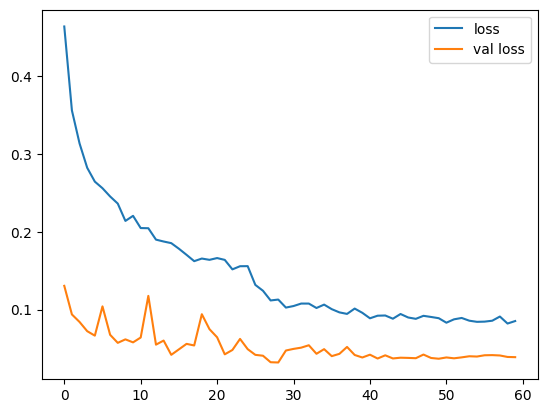

In [37]:
plt.plot(ft_history['loss'], label='loss')
plt.plot(ft_history['val_loss'], label='val loss')
plt.legend()

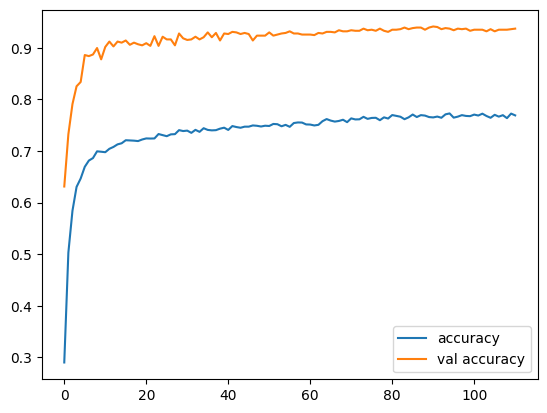

In [38]:
plt.plot(tl_history['accuracy'], label='accuracy')
plt.plot(tl_history['val_accuracy'], label='val accuracy')
plt.legend()

## 🕹️ Prediction on Test set

In [39]:
model = tfk.models.load_model('weights.keras')

predictions = model.predict(X_test)
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print("test loss: ",test_loss)

75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 76ms/step - accuracy: 0.9893 - loss: 0.0528
test loss:  0.05651926249265671


Accuracy score over the test set: 0.9895
Precision score over the test set: 0.9896
Recall score over the test set: 0.9895
F1 score over the test set: 0.9896


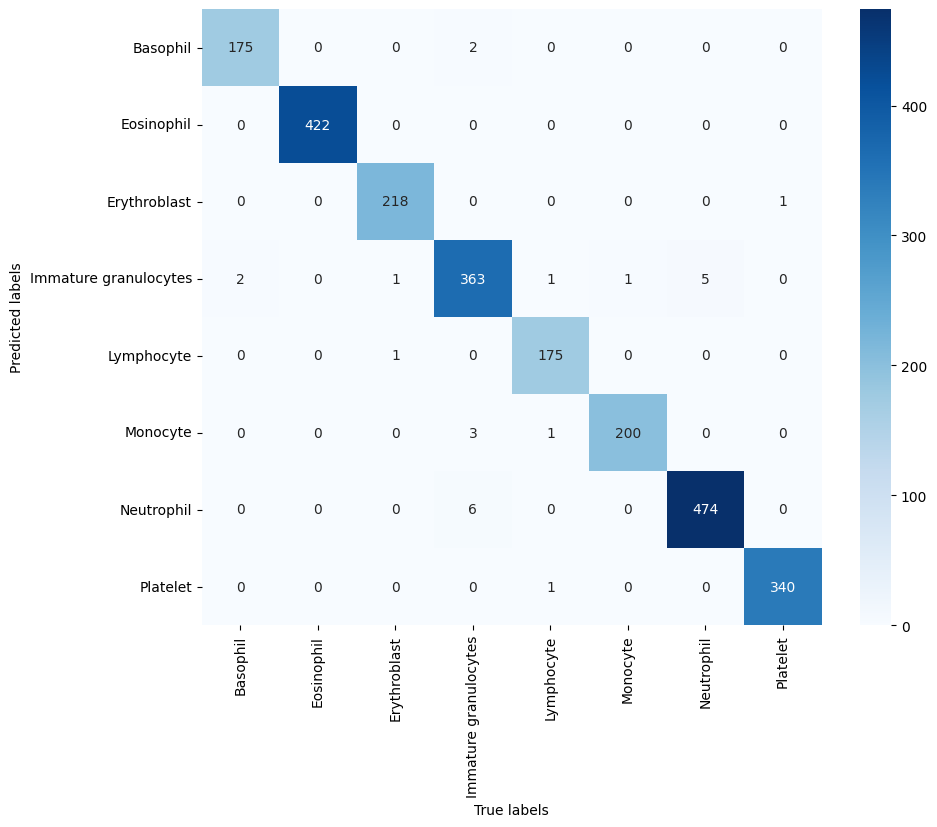

In [40]:
pred_classes = np.argmax(predictions, axis=-1)
true_classes = np.argmax(Y_test, axis=-1) # Extract ground truth classes

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

 # Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape) # Combine numbers and percentages into a single string for annotation

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## 📊 Prepare Your Submission



To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:



```python

# file: model.py

class Model:

    def __init__(self):

        """Initialize the internal state of the model."""



    def predict(self, X):

        """Return a numpy array with the labels corresponding to the input X."""

```



The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.



❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [41]:
%%writefile model.py

import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.
        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.
        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        preds = np.argmax(preds, axis=1)

        return preds

Writing model.py


In [42]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'
print(filename)

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

submission_241122_143042.zip


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: model.py (deflated 56%)
  adding: weights.keras (deflated 7%)
